# Word embeddings

Here we'll play around with word embeddings taken from the library [spaCy](https://spacy.io).

## Load word embeddings via spaCy

The NLP library spaCy provides language models with word embeddings for a variety of languages. We download a language model for English as follows:

In [1]:
import spacy
MODEL = 'en_core_web_md'

spacy.cli.download(MODEL)
nlp = spacy.load(MODEL)
vocab = nlp.vocab

2021-09-24 11:06:27.718447: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-24 11:06:27.718467: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Now we can access these word vectors as follows:

In [3]:
vector = vocab.get_vector('dog')
vector.shape, vector

((300,),
 array([-4.0176e-01,  3.7057e-01,  2.1281e-02, -3.4125e-01,  4.9538e-02,
         2.9440e-01, -1.7376e-01, -2.7982e-01,  6.7622e-02,  2.1693e+00,
        -6.2691e-01,  2.9106e-01, -6.7270e-01,  2.3319e-01, -3.4264e-01,
         1.8311e-01,  5.0226e-01,  1.0689e+00,  1.4698e-01, -4.5230e-01,
        -4.1827e-01, -1.5967e-01,  2.6748e-01, -4.8867e-01,  3.6462e-01,
        -4.3403e-02, -2.4474e-01, -4.1752e-01,  8.9088e-02, -2.5552e-01,
        -5.5695e-01,  1.2243e-01, -8.3526e-02,  5.5095e-01,  3.6410e-01,
         1.5361e-01,  5.5738e-01, -9.0702e-01, -4.9098e-02,  3.8580e-01,
         3.8000e-01,  1.4425e-01, -2.7221e-01, -3.7016e-01, -1.2904e-01,
        -1.5085e-01, -3.8076e-01,  4.9583e-02,  1.2755e-01, -8.2788e-02,
         1.4339e-01,  3.2537e-01,  2.7226e-01,  4.3632e-01, -3.1769e-01,
         7.9405e-01,  2.6529e-01,  1.0135e-01, -3.3279e-01,  4.3117e-01,
         1.6687e-01,  1.0729e-01,  8.9418e-02,  2.8635e-01,  4.0117e-01,
        -3.9222e-01,  4.5217e-01,  1.3521e

## Word similarity

Word embeddings suffice to play games like "find the odd one out", where we're given a list of words and have to find out the one that stands out.

We start with a function that computes a similarity matrix between words:

In [5]:
import numpy as np
import pandas as pd

In [7]:
words = ['dog', 'cat', 'shoe']

vectors = np.stack([vocab.get_vector(word) for word in words])
vectors.shape


(3, 300)

In [8]:
np.matmul(vectors, vectors.transpose())


array([[49.472538, 37.67176 , 13.987656],
       [37.67176 , 44.633343, 10.925957],
       [13.987656, 10.925957, 46.19839 ]], dtype=float32)

In [13]:
norms = np.expand_dims(np.linalg.norm(vectors, axis=1), 1)
normed_vectors = vectors / norms
normed_vectors.shape

(3, 300)

In [14]:
def similarity(words):
    vectors = np.stack([vocab.get_vector(word) for word in words])
    norms = np.expand_dims(np.linalg.norm(vectors, axis=1), 1)
    vectors = vectors / norms
    matrix = np.matmul(vectors, vectors.transpose())
    return pd.DataFrame(matrix, index=words, columns=words)

similarity(words)

dog       cat      shoe
dog   1.000000  0.801685  0.292583
cat   0.801685  1.000000  0.240611
shoe  0.292583  0.240611  1.000000

Let's plot a heatmap of the similarities:

<AxesSubplot:>

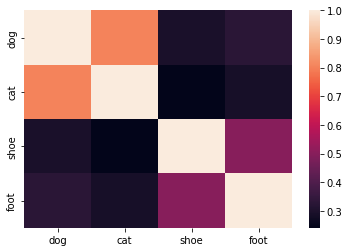

In [17]:
import seaborn as sns
%matplotlib inline

words = ['dog', 'cat', 'shoe', 'foot']
sns.heatmap(similarity(words))

## "Find the odd one out"

Now let's implement the game.

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

def find_the_odd_one(words):
    matrix = similarity(words)
    index = np.argmin(matrix.sum(axis=1))
    return words[index]

find_the_odd_one(words)

'shoe'

Let's try it:

In [20]:
find_the_odd_one(['screen', 'graphics', 'cooking', 'programming'])

'cooking'

## Visualizing word embeddings

To visualize word embeddings, we need to project them into two-dimensional space. 
This task calls for classical dimensionality rediction methods like PCA (principal component analysis).

In [21]:
from sklearn import decomposition

def pca(words):
    vectors = np.array(list(map(vocab.get_vector, words)))
    vectors_2d = decomposition.PCA(2).fit_transform(vectors)
    return pd.DataFrame(vectors_2d, columns=['x', 'y'], index=words)
    
pca(words)

x         y
dog  -3.489333 -0.262913
cat  -3.545729 -0.086090
shoe  3.886673 -3.144358
foot  3.148387  3.493360

In [22]:
import altair as alt

def project(words):
    df = pca(words).reset_index().rename(columns={'index':'Wort'})
    base = alt.Chart(df).encode(x='x', y='y')
    return base.mark_point() + base.encode(text='Wort').mark_text(dy=10)

In [25]:
project(['cat', 'dog', 'ape', 'foot', 'shoe'])

alt.LayerChart(...)

In [26]:
project(['Paris', 'France', 'London', 'UK', 'Berlin', 'Germany'])

alt.LayerChart(...)